# Shape Classification Using Keras

This notebook shows how to utilize generators to create synthetic "images" for multi-output classification. We will be using the [cairo](https://pycairo.readthedocs.io/en/latest/) library to create simple shapes with different colors on a white background. We will then create a network using [Keras](https://keras.io/) that will be able to both classify our images based on their shape and their color (at the same time).


A good resource for using keras for multiple outputs and multiple losses (using a more complicated image collection/network) is: https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import cairo

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras import backend as K
from keras.metrics import categorical_accuracy

from utility import generate_images_with_bboxes, display_image_with_bboxes

Using TensorFlow backend.


In [2]:
SEED = 100

img_size = 32
min_object_size = 8
max_object_size = 16

shape_labels = ['Rectangle', 'Circle', 'Triangle']
color_labels = ['Red', 'Green', 'Blue']

## Image Generator
We want to be able to produce on-demand batches of images with their corresponding labels. We start with a function that will create a set number of images that contain a random shape (rectangle, circle, or triangle) as well as a random color (red, green, blue). Then we make the generator function in order to produce on-demand batches. We are also going to create a display function (mainly for sanity checking).

In [3]:
def create_images(num_imgs=1, img_size=32, min_object_size=8, max_object_size=16):
    imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)
    shapes = np.zeros(num_imgs, dtype=int)
    num_shapes = 3
    colors = np.zeros(num_imgs, dtype=int)
    num_colors = 3
    for img_ in range(num_imgs):
        surface = cairo.ImageSurface.create_for_data(imgs[img_], cairo.FORMAT_ARGB32, img_size, img_size)
        cr = cairo.Context(surface)
        # Background is white
        cr.set_source_rgb(1, 1, 1)
        cr.paint()
        
        shape = np.random.randint(num_shapes)
        shapes[img_] = shape
        if shape == 0:
            # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            cr.rectangle(x, y, w, h)
        elif shape == 1:
            # circle
            r = 0.5 * np.random.randint(min_object_size, max_object_size)
            x = np.random.randint(r, img_size - r)
            y = np.random.randint(r, img_size - r)
            cr.arc(x, y, r, 0, 2 * np.pi)
        else:
            # triangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            cr.move_to(x, y)
            cr.line_to(x + w, y)
            cr.line_to(x + w, y + h)
            cr.line_to(x, y)
            cr.close_path()

        color = np.random.randint(num_colors)
        colors[img_] = color
        rgb = [0, 0, 0]
        rgb[color] = 1
        # Add some randomness to color at some point - Not critical for now though
        cr.set_source_rgb(rgb[0], rgb[1], rgb[2])
        cr.fill()

    imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB
    return imgs, shapes, colors
        

def image_batch_generator(batch_size=32, img_size=32, min_object_size=8, max_object_size=16):
    while True:
        imgs, shape, color = create_images(batch_size, img_size, min_object_size, max_object_size)
        shape_one_hot = to_categorical(shape, num_classes=3)
        color_one_hot = to_categorical(color, num_classes=3)
        yield imgs, [shape_one_hot, color_one_hot]
        
        
def display_image_with_color_shape(image, shape, color, axes=None):
    shape = np.argmax(shape)
    color = np.argmax(color)
    plt.imshow(image, origin='lower', extent=[0, 32, 0, 32])
    plt.annotate(shape_labels[shape], (3, 3), color=color_labels[color], clip_on=False)

Text(0.5,1,'Blue Rectangle')

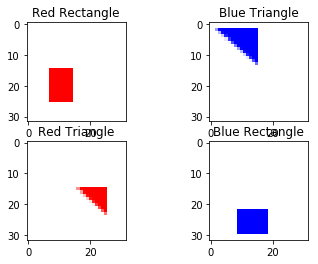

In [4]:
np.random.seed(100)
test_gen = image_batch_generator(batch_size=4)
# We just want one "batch"
images, (shapes, colors) = test_gen.__next__()

# We need to do a bit of manipulation of the labels as they are one-hot encoded
plt.subplot(221)
index = 0
plt.imshow(images[index])
plt.title(color_labels[np.argmax(colors[index])] + ' ' + shape_labels[np.argmax(shapes[index])])

plt.subplot(222)
index = 1
plt.imshow(images[index])
plt.title(color_labels[np.argmax(colors[index])] + ' ' + shape_labels[np.argmax(shapes[index])])

plt.subplot(223)
index = 2
plt.imshow(images[index])
plt.title(color_labels[np.argmax(colors[index])] + ' ' + shape_labels[np.argmax(shapes[index])])

plt.subplot(224)
index = 3
plt.imshow(images[index])
plt.title(color_labels[np.argmax(colors[index])] + ' ' + shape_labels[np.argmax(shapes[index])])


In [12]:
def build_shape_branch(inputs, num_shapes,
    finalAct="softmax", chanDim=-1, name="shape_output"):
    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)

    # (CONV => RELU) * 2 => POOL
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # (CONV => RELU) * 2 => POOL
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_shapes)(x)
    x = Activation(finalAct, name=name)(x)

    # return the category prediction sub-network
    return x

In [13]:
def build_color_branch(inputs, num_colors, finalAct="softmax",
    chanDim=-1, name="color_output"):
    # CONV => RELU => POOL
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)

    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # define a branch of output layers for the number of different
    # colors (i.e., red, black, blue, etc.)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_colors)(x)
    x = Activation(finalAct, name=name)(x)

    # return the color prediction sub-network
    return x

In [14]:
def build(input_shape, finalAct="softmax"):
    inputs = Input(shape=input_shape)    
    shape_branch = build_shape_branch(inputs, num_shapes=3, name="shape_output")
    color_branch = build_color_branch(inputs, num_colors=3, name="color_output")  
    
    model = Model(
        inputs=inputs,
        outputs=[
            shape_branch, color_branch
        ],
        name="shape_net"
    )
    
    return model

In [15]:
batch_size = 32
samples_per_epoch = 5000
steps_per_epoch = samples_per_epoch // batch_size
num_epochs = 20

In [16]:
losses = {
    "shape_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
}

model = build([32, 32, 3])
model.compile(optimizer='adadelta', loss=losses, metrics=["accuracy"])

train_gen = image_batch_generator(batch_size=batch_size)
valid_gen = image_batch_generator(batch_size=batch_size)

In [17]:
hist = model.fit_generator(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=valid_gen,
    validation_steps=steps_per_epoch,
    use_multiprocessing=True
    )

Epoch 1/20
156/156 [==============================] - 7s 45ms/step - loss: 0.6213 - shape_output_loss: 0.4693 - color_output_loss: 0.1520 - shape_output_acc: 0.8277 - color_output_acc: 0.9497 - val_loss: 1.0371 - val_shape_output_loss: 0.9025 - val_color_output_loss: 0.1347 - val_shape_output_acc: 0.7372 - val_color_output_acc: 0.9349
Epoch 2/20
156/156 [==============================] - 5s 30ms/step - loss: 0.0660 - shape_output_loss: 0.0554 - color_output_loss: 0.0106 - shape_output_acc: 0.9822 - color_output_acc: 0.9974 - val_loss: 0.3581 - val_shape_output_loss: 0.3579 - val_color_output_loss: 1.7161e-04 - val_shape_output_acc: 0.8998 - val_color_output_acc: 1.0000
Epoch 3/20
156/156 [==============================] - 5s 30ms/step - loss: 0.0435 - shape_output_loss: 0.0395 - color_output_loss: 0.0039 - shape_output_acc: 0.9854 - color_output_acc: 0.9992 - val_loss: 1.0802 - val_shape_output_loss: 1.0740 - val_color_output_loss: 0.0061 - val_shape_output_acc: 0.6416 - val_color_outp

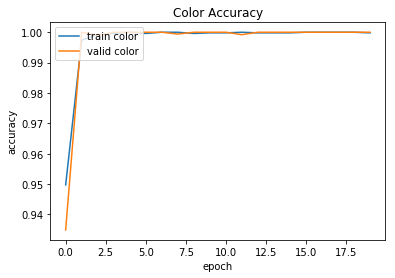

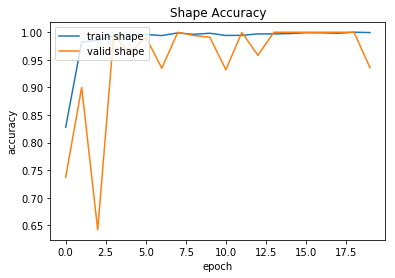

In [18]:
plt.plot(hist.history['color_output_acc'])
plt.plot(hist.history['val_color_output_acc'])
plt.title('Color Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train color', 'valid color'], loc='upper left')
plt.show()

plt.plot(hist.history['shape_output_acc'])
plt.plot(hist.history['val_shape_output_acc'])
plt.title('Shape Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train shape', 'valid shape'], loc='upper left')
plt.show()